In [2]:
!pip install keras

  Using cached https://files.pythonhosted.org/packages/5e/10/aa32dad071ce52b5502266b5c659451cfd6ffcbf14e6c8c4f16c0ff5aaab/Keras-2.2.4-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/c0/bf/0315ef6a9fd3fc2346e85b0ff1f5f83ca17073f2c31ac719ab2e4da0d4a3/Keras_Preprocessing-1.0.9-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/90/85/64c82949765cfb246bbdaf5aca2d55f400f792655927a017710a78445def/Keras_Applications-1.0.7-py2.py3-none-any.whl


In [3]:
import pandas as pd
import numpy as np

from scipy import stats

import matplotlib.pyplot as plt

from keras.models import model_from_json

from keras.metrics import categorical_accuracy

import keras

import random

%matplotlib inline

Using TensorFlow backend.


### Helper functions

In [4]:
def load_data(dataset: str, channels: int = 1):
  
    df = pd.read_csv(dataset)
  
    df['category'] = df['category'].str.strip()

    train = df.loc[df.category == 'Training',:]
    valid = df.loc[df.category == 'PublicTest',:]
    test  = df.loc[df.category == 'PrivateTest',:]

    del train['Unnamed: 0']
    del valid['Unnamed: 0']
    del test['Unnamed: 0']

    X_train = np.array(train.iloc[:, 1:2305])
    y_train = np.array(train.loc[:, ['y']])

    X_val = np.array(valid.iloc[:, 1:2305])
    y_val = np.array(valid.loc[:, ['y']])

    X_test = np.array(test.iloc[:, 1:2305])
    y_test = np.array(test.loc[:, ['y']])

    del train
    del valid
    del test

    y_train = keras.utils.to_categorical(y_train, 7)
    y_val = keras.utils.to_categorical(y_val, 7)
    y_test = keras.utils.to_categorical(y_test, 7)

    X_train_r = X_train.reshape((len(X_train), 48, 48))
    X_val_r   = X_val.reshape((len(X_val), 48, 48))
    X_test_r   = X_test.reshape((len(X_test), 48, 48))

    X_train_r = X_train_r / 255
    X_val_r = X_val_r / 255
    X_test_r = X_test_r / 255

    if channels == 1:
        X_train_bw = X_train_r.reshape((len(X_train_r), 48, 48, 1))
        X_val_bw = X_val_r.reshape((len(X_val_r), 48, 48, 1))
        X_test_bw = X_test_r.reshape((len(X_test_r), 48, 48, 1))
        return (X_train_bw, X_val_bw, X_test_bw, y_train, y_val, y_test)
    elif channels == 3:
        X_train_rgb = np.stack((X_train_r,) * 3, axis = -1)
        X_val_rgb = np.stack((X_val_r, ) * 3, axis = -1)
        X_test_rgb = np.stack((X_test_r, ) * 3, axis = -1)
        return (X_train_rgb, X_val_rgb, X_test_rgb, y_train, y_val, y_test)
    else:
        return None

In [5]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontdict = {'fontsize': 20})
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

### Read data

In [7]:
X_train_bw, X_val_bw, X_test_bw, y_train, y_val, y_test = load_data('emotions.csv')

In [8]:
import collections
dict(collections.Counter(np.argmax(y_train, axis = 1)))

{0: 3995, 1: 436, 2: 4097, 3: 7215, 4: 4830, 5: 3171, 6: 4965}

### Modeling

In [16]:
from keras.models import Sequential
from keras.optimizers import SGD,Adadelta
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D,AveragePooling2D
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D,GlobalAveragePooling2D
from keras.layers import Input, Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers.advanced_activations import PReLU

from keras.metrics import categorical_accuracy

np.random.seed(100)

### VGG-19 Model

In [17]:
img_rows, img_cols = 48, 48

model = Sequential()

model.add(Conv2D(64, (3, 3), name='block1_conv1', activation='relu', padding="same",
                        input_shape=(img_rows, img_cols, 1)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Conv2D(64, (3, 3), name='block1_conv2', activation='relu', padding="same"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='block1_pool'))
model.add(Dropout(0.5))
          
model.add(Conv2D(128, (3, 3), name='block2_conv1', activation='relu', padding="same"))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Conv2D(128, (3, 3), name='block2_conv2', activation='relu', padding="same"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='block2_pool'))
model.add(Dropout(0.5))

model.add(Conv2D(256, (3, 3), name='block3_conv1', activation='relu', padding="same"))
model.add(Dropout(0.5))

model.add(BatchNormalization())
model.add(Conv2D(256, (3, 3), name='block3_conv2', activation='relu', padding="same"))
model.add(Dropout(0.5))

model.add(BatchNormalization())
model.add(Conv2D(256, (3, 3), name='block3_conv3', activation='relu', padding="same"))
model.add(Dropout(0.5))

model.add(BatchNormalization())
model.add(Conv2D(256, (3, 3), name='block3_conv4', activation='relu', padding="same"))
model.add(Dropout(0.2))

model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='block3_pool'))
model.add(Dropout(0.5))
    
model.add(Conv2D(512, (3, 3), name='block4_conv1', activation='relu', padding="same"))
model.add(Dropout(0.5))

model.add(BatchNormalization())
model.add(Conv2D(512, (3, 3), name='block4_conv2', activation='relu', padding="same"))
model.add(Dropout(0.5))

model.add(BatchNormalization())
model.add(Conv2D(512, (3, 3), name='block4_conv3', activation='relu', padding="same"))
model.add(Dropout(0.5))

model.add(BatchNormalization())
model.add(Conv2D(512, (3, 3), name='block4_conv4', activation='relu', padding="same"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='block4_pool'))
model.add(Dropout(0.5))

model.add(Conv2D(512, (3, 3), name='block5_conv1', activation='relu', padding="same"))
model.add(Dropout(0.5))

model.add(BatchNormalization())
model.add(Conv2D(512, (3, 3), name='block5_conv2', activation='relu', padding="same"))
model.add(Dropout(0.5))

model.add(BatchNormalization())
model.add(Conv2D(512, (3, 3), name='block5_conv3', activation='relu', padding="same"))
model.add(Dropout(0.5))

model.add(BatchNormalization())
model.add(Conv2D(512, (3, 3), name='block5_conv4', activation='relu', padding="same"))
model.add(Dropout(0.5))

model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='block5_pool'))
model.add(Dropout(0.5))
               
#model.add(GlobalAveragePooling2D())

model.add(Flatten(name='flatten'))

model.add(Dense(4096, activation='relu', name='fc1'))
model.add(Dropout(0.5))

model.add(Dense(4096, activation='relu', name='fc2'))
model.add(Dropout(0.5))

model.add(Dense(7, activation='softmax', name='predictions'))

# ada = Adadelta(lr=0.1, rho=0.95, epsilon=1e-08)
model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=[categorical_accuracy])


In [18]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 64)        256       
_________________________________________________________________
dropout_3 (Dropout)          (None, 48, 48, 64)        0         
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 48, 48, 64)        256       
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 24, 24, 64)        0         
__________

In [25]:
batch_size = 32
epochs = 3

### Training with augmented data. Augmentation takes place while training

In [28]:
from keras.preprocessing.image import ImageDataGenerator

#Generate augmented data

# datagen = ImageDataGenerator(
#     featurewise_center=False,  # set input mean to 0 over the dataset
#     samplewise_center=False,  # set each sample mean to 0
#     featurewise_std_normalization=False,  # divide inputs by std of the dataset
#     samplewise_std_normalization=False,  # divide each input by its std
#     zca_whitening=False,  # apply ZCA whitening
#     rotation_range=25,  # randomly rotate images in the range (degrees, 0 to 180)
#     width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
#     height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
#     horizontal_flip=True,  # randomly flip images
#     vertical_flip=False)  # randomly flip images

# valgen = ImageDataGenerator(
#     featurewise_center=False,  # set input mean to 0 over the dataset
#     samplewise_center=False,  # set each sample mean to 0
#     featurewise_std_normalization=False,  # divide inputs by std of the dataset
#     samplewise_std_normalization=False,  # divide each input by its std
#     zca_whitening=False,  # apply ZCA whitening
#     rotation_range=25,  # randomly rotate images in the range (degrees, 0 to 180)
#     width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
#     height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
#     horizontal_flip=True,  # randomly flip images
#     vertical_flip=False) 

# datagen.fit(X_train_bw)
# valgen.fit(X_val_bw)

model.load_weights('vgg19-other.h5')

model.fit(X_train_bw, y_train, batch_size=128, epochs=50, validation_data=(X_val_bw, y_val))

#Note: Given training is done using best checkpoint saved after 200 epochs



Train on 28709 samples, validate on 3589 samples
Epoch 1/50
28709/28709 [==============================] - 99s 3ms/step - loss: 0.7151 - categorical_accuracy: 0.7464 - val_loss: 1.0220 - val_categorical_accuracy: 0.6517
Epoch 2/50
28709/28709 [==============================] - 99s 3ms/step - loss: 0.7002 - categorical_accuracy: 0.7512 - val_loss: 0.9959 - val_categorical_accuracy: 0.6665
Epoch 3/50
28709/28709 [==============================] - 99s 3ms/step - loss: 0.7010 - categorical_accuracy: 0.7513 - val_loss: 0.9971 - val_categorical_accuracy: 0.6673
Epoch 4/50
28709/28709 [==============================] - 99s 3ms/step - loss: 0.6978 - categorical_accuracy: 0.7505 - val_loss: 0.9853 - val_categorical_accuracy: 0.6662
Epoch 5/50
28709/28709 [==============================] - 99s 3ms/step - loss: 0.6910 - categorical_accuracy: 0.7555 - val_loss: 1.0497 - val_categorical_accuracy: 0.6495
Epoch 6/50
28709/28709 [==============================] - 99s 3ms/step - loss: 0.6879 - categori

In [30]:
model.save_weights('vgg19-other.h5')

In [21]:
model_json = model.to_json()

In [22]:
with open("vgg19-other.json", "w") as json_file:
    json_file.write(model_json)

#### Data Augmentation

In [28]:
#batch_size=32

In [32]:
#from keras.preprocessing.image import ImageDataGenerator
#from keras.preprocessing.image import array_to_img, img_to_array, load_img

#gen = ImageDataGenerator(
#    rotation_range=20,
#    width_shift_range=0.2,
#    height_shift_range=0.2,
#    horizontal_flip=True
#)

#train_generator=gen.flow(x=X_train_r, 
#                         y=y_train, 
#                         batch_size=batch_size)

In [33]:
#validation_generator=gen.flow(x=X_val_r, 
#                         y=y_val, 
#                         batch_size=batch_size)

#### Iteration

In [28]:
def read_model_from_disk(model: str, weights: str):
    
    json_file = open(model, 'r')
    
    loaded_model = json_file.read()
    
    model = model_from_json(loaded_model)
    
    model.load_weights(weights)
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[categorical_accuracy])
    
    return model

In [29]:
model_saved = read_model_from_disk(model='../models/model_deep.json', weights='../models/weights/complex_20_cc_2.h5')

### Evaluations

In [29]:
model.evaluate(X_test_bw, y = y_test, verbose=1)

3589/3589 [==============================] - 5s 1ms/step


[0.997017162030173, 0.6753970465476747]

Our baseline model gave `63%` accuracy on test dataset. In the original competition leaderboard, it would be in top 10 submissions. We think, that it is absolutely possible to get even higher accuracy by training the model for larger number of epochs.

### Investigation

In [31]:
from sklearn.metrics import confusion_matrix

In [32]:
y = pd.DataFrame(np.argmax(y_test, axis = 1), columns=['true'])

In [35]:
y['pred'] = model.predict_classes(X_test_bw)

In [37]:
mapping = {
    0: 'Angry', 
    1: 'Disgust', 
    2: 'Fear', 
    3: 'Happy', 
    4: 'Sad', 
    5: 'Surprise', 
    6: 'Neutral'   
}

y['true'] = y['true'].map(mapping)

In [38]:
y['pred'] = y['pred'].map(mapping)

In [39]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontdict = {'fontsize': 20})
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


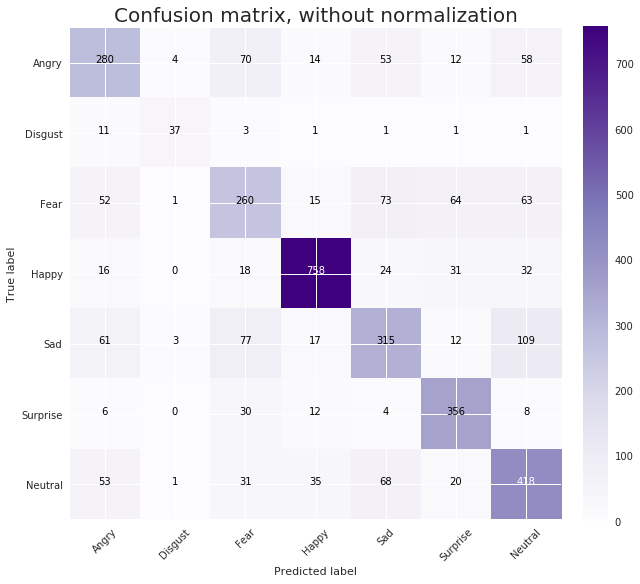

In [40]:
cnf_matrix = confusion_matrix(y['true'], y['pred'],
                              labels=['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'])

np.set_printoptions(precision=2)


plt.figure(figsize=(9, 9))
plot_confusion_matrix(cnf_matrix, 
                      classes=['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'],
                      title='Confusion matrix, without normalization', cmap = 'Purples')

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


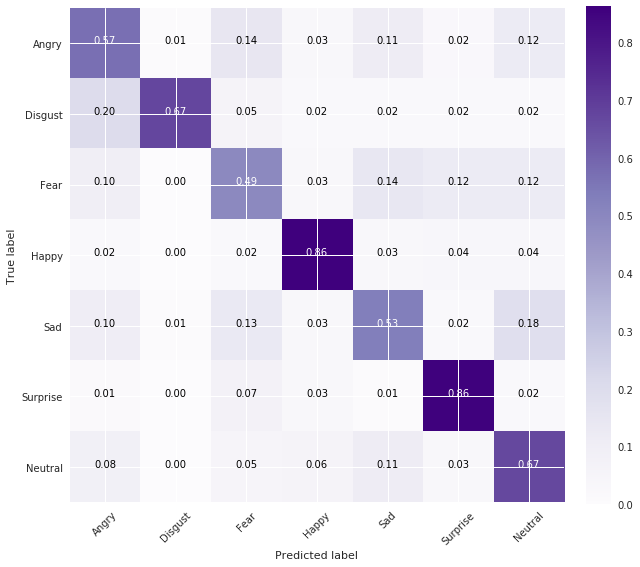

In [42]:
plt.figure(figsize=(9, 9))
plot_confusion_matrix(cnf_matrix, 
                      classes=['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'],
                      normalize=True,
                      title='', cmap = 'Purples')